# Idea & Hypothesis

- **Hypothesis**:`CpGs with high perturbation == more signal / information`
	- More weight = more perturbation = more relevant to AE reconstruction = important CpGs capturing signal (GWAS analogy: SNPs vs Imputed area)

--> More often in EWAS than CpGs with no perturbation (trait specific, trait agnostic)
--> Better reconstruction accuracy
--> Predictive for phenotype

In [5]:
import pandas as pd
import numpy as np
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json 

import random
import copy

from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr

sns.set_theme(style="ticks", font_scale=1.8)

c_high = sns.color_palette("Blues")[5]
c_low = sns.color_palette("Blues")[3]
c_none = sns.color_palette("Blues")[1]

In [6]:
'''
Merge highly connected CpGs of all chromosomes
'''
all_cpgs_high = []
all_cpgs_low = []
all_cpgs_none = []
df = pd.DataFrame(columns = [f"chr{i}" for i in range(1,23)], index=["global_high", "global_low", "global_none"])
for CHR in [f"chr{i}" for i in range(1,23)]:
    print(CHR)
    PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"
    PATH_model= f"logs/finalModels/{CHR}"
    PATH_perturbation = f"results/{CHR}/perturbations"

    # Load CpG connections
    with open(f"{PATH_perturbation}/global_connectivity_groups.pkl", "rb") as f: dic_globalConn = pickle.load(f)
    chr_idx_cpgs_high = dic_globalConn["global_high"]
    chr_idx_cpgs_low = dic_globalConn["global_low"]
    chr_idx_cpgs_none = dic_globalConn["global_none"]
    print(f"High CpGs: {len(chr_idx_cpgs_high)}\nLow CpGs: {len(chr_idx_cpgs_low)}\nNone CpGs: {len(chr_idx_cpgs_none)}\n")
    
    ''' 
    Get statistics
    '''
    sumcpgs = len(chr_idx_cpgs_high + chr_idx_cpgs_low + chr_idx_cpgs_none)
    df.loc["global_high",CHR] = (len(chr_idx_cpgs_high)/sumcpgs)*100
    df.loc["global_low",CHR] = (len(chr_idx_cpgs_low)/sumcpgs)*100
    df.loc["global_none",CHR] = (len(chr_idx_cpgs_none)/sumcpgs)*100
    
    all_cpgs_high = all_cpgs_high + chr_idx_cpgs_high
    all_cpgs_low = all_cpgs_low + chr_idx_cpgs_low
    all_cpgs_none = all_cpgs_none + chr_idx_cpgs_none
    
print(f"\n\nAll Chromosomes - High CpGs: {len(all_cpgs_high)}\nAll Chromosomes - Low CpGs: {len(all_cpgs_low)}\nAll Chromosomes - None CpGs: {len(all_cpgs_none)}\n")

chr1
High CpGs: 2825
Low CpGs: 17104
None CpGs: 9553

chr2
High CpGs: 2247
Low CpGs: 12558
None CpGs: 7179

chr3
High CpGs: 1637
Low CpGs: 7250
None CpGs: 6660

chr4
High CpGs: 1291
Low CpGs: 6511
None CpGs: 5298

chr5
High CpGs: 1558
Low CpGs: 6773
None CpGs: 7634

chr6
High CpGs: 1869
Low CpGs: 11702
None CpGs: 9499

chr7
High CpGs: 1801
Low CpGs: 11772
None CpGs: 6026

chr8
High CpGs: 1742
Low CpGs: 8211
None CpGs: 3751

chr9
High CpGs: 724
Low CpGs: 3938
None CpGs: 1957

chr10
High CpGs: 1426
Low CpGs: 7797
None CpGs: 6513

chr11
High CpGs: 2045
Low CpGs: 10118
None CpGs: 6407

chr12
High CpGs: 1588
Low CpGs: 7374
None CpGs: 6203

chr13
High CpGs: 851
Low CpGs: 4739
None CpGs: 2212

chr14
High CpGs: 926
Low CpGs: 8059
None CpGs: 432

chr15
High CpGs: 1001
Low CpGs: 8263
None CpGs: 451

chr16
High CpGs: 1639
Low CpGs: 11763
None CpGs: 421

chr17
High CpGs: 2153
Low CpGs: 14488
None CpGs: 403

chr18
High CpGs: 355
Low CpGs: 1957
None CpGs: 1342

chr19
High CpGs: 1958
Low CpGs: 13056


In [7]:
df

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chr20,chr21,chr22
global_high,9.582118,10.22107,10.529363,9.854962,9.758847,8.10143,9.189244,12.711617,10.938208,9.062023,...,10.90746,9.83328,10.303654,11.85705,12.632011,9.71538,12.652666,9.654332,7.833762,8.888041
global_low,58.01506,57.123362,46.632791,49.70229,42.424053,50.723884,60.064289,59.916813,59.495392,49.548805,...,60.740836,85.579272,85.05404,85.097302,85.00352,53.557745,84.368336,66.77326,43.729312,53.232882
global_none,32.402822,32.655568,42.837847,40.442748,47.8171,41.174686,30.746467,27.37157,29.5664,41.389171,...,28.351705,4.587448,4.642306,3.045649,2.364468,36.726875,2.978998,23.572407,48.436925,37.879077


In [8]:
print(df.mean(axis=1))
print(df.std(axis=1))

global_high    10.259563
global_low     60.904277
global_none    28.836160
dtype: float64
global_high     1.348871
global_low     14.593748
global_none    15.393589
dtype: float64


# High (global) connectivity == High reconstruction accuracy?

- better for CpGs with higher perturbation?
--> check on test dataset to avoid overfitting1

In [25]:
all_r_high = []
all_r_low = []
all_r_none = []

all_std_high = []
all_std_low = []
all_std_none = []

all_mean_high = []
all_mean_low = []
all_mean_none = []

for CHR in [f"chr{i}" for i in range(1,23)]:
    print(CHR)
    PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"
    PATH_perturbation = f"results/{CHR}/perturbations"

    # Load CpG connections
    with open(f"{PATH_perturbation}/global_connectivity_groups.pkl", "rb") as f: dic_globalConn = pickle.load(f)
    chr_idx_cpgs_high = dic_globalConn["global_high"]
    chr_idx_cpgs_low = dic_globalConn["global_low"]
    chr_idx_cpgs_none = dic_globalConn["global_none"]
    print(f"High CpGs: {len(chr_idx_cpgs_high)}\nLow CpGs: {len(chr_idx_cpgs_low)}\nNone CpGs: {len(chr_idx_cpgs_none)}\n")
    
    ## Load Data
    with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f)     ##### CHANGED THIS FROM TEST TO TRAINING
    test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)
    df_orig = test_dataset["beta"]
    
    ## Load model
    PATH_model= f"logs/finalModels/{CHR}"
    with open(f"{PATH_model}/param_grid.json", "r") as f: dict_bestModel = json.load(f)
    latSize = dict_bestModel["latentSize"]
    name = f"latSize_{latSize}"
    model = torch.load(f"{PATH_model}/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

    ## Generate reconstruction
    with torch.no_grad():
        recon_test = model(test_tensor).detach().numpy()
    df_recon = pd.DataFrame(recon_test, columns=test_dataset["beta"].columns)
    
    ### Calculate average reconstruction accuracy for each CpG through pearson correlation 
    all_r_high = all_r_high + [pearsonr(df_orig.loc[:,i], df_recon.loc[:,i])[0] for i in chr_idx_cpgs_high]
    all_r_low = all_r_low + [pearsonr(df_orig.loc[:,i], df_recon.loc[:,i])[0] for i in chr_idx_cpgs_low]
    all_r_none = all_r_none + [pearsonr(df_orig.loc[:,i], df_recon.loc[:,i])[0] for i in chr_idx_cpgs_none]
    
    ### Calculate average standard deviation of beta values 
    all_std_high = all_std_high + df_orig.loc[:,chr_idx_cpgs_high].std().tolist()
    all_std_low = all_std_low + df_orig.loc[:,chr_idx_cpgs_low].std().tolist()
    all_std_none = all_std_none + df_orig.loc[:,chr_idx_cpgs_none].std().tolist()

    ### Calculate average mean of beta values 
    all_mean_high = all_mean_high + df_orig.loc[:,chr_idx_cpgs_high].mean().tolist()
    all_mean_low = all_mean_low + df_orig.loc[:,chr_idx_cpgs_low].mean().tolist()
    all_mean_none = all_mean_none + df_orig.loc[:,chr_idx_cpgs_none].mean().tolist()



chr1
High CpGs: 2825
Low CpGs: 17104
None CpGs: 9553

chr2
High CpGs: 2247
Low CpGs: 12558
None CpGs: 7179

chr3
High CpGs: 1637
Low CpGs: 7250
None CpGs: 6660

chr4
High CpGs: 1291
Low CpGs: 6511
None CpGs: 5298

chr5
High CpGs: 1558
Low CpGs: 6773
None CpGs: 7634

chr6
High CpGs: 1869
Low CpGs: 11702
None CpGs: 9499

chr7
High CpGs: 1801
Low CpGs: 11772
None CpGs: 6026

chr8
High CpGs: 1742
Low CpGs: 8211
None CpGs: 3751

chr9
High CpGs: 724
Low CpGs: 3938
None CpGs: 1957

chr10
High CpGs: 1426
Low CpGs: 7797
None CpGs: 6513

chr11
High CpGs: 2045
Low CpGs: 10118
None CpGs: 6407

chr12
High CpGs: 1588
Low CpGs: 7374
None CpGs: 6203

chr13
High CpGs: 851
Low CpGs: 4739
None CpGs: 2212

chr14
High CpGs: 926
Low CpGs: 8059
None CpGs: 432

chr15
High CpGs: 1001
Low CpGs: 8263
None CpGs: 451

chr16
High CpGs: 1639
Low CpGs: 11763
None CpGs: 421

chr17
High CpGs: 2153
Low CpGs: 14488
None CpGs: 403

chr18
High CpGs: 355
Low CpGs: 1957
None CpGs: 1342

chr19
High CpGs: 1958
Low CpGs: 13056


In [26]:
'''
Doesn't really hold anymore...
'''
# df = pd.DataFrame([all_r_high, all_r_low, all_r_none], index=["high", "low","none"]).T

# fig, ax = plt.subplots(figsize=(10, 8))
# sns.boxplot(data=df.melt(), x="variable", y="value", ax=ax, palette=[c_high, c_low, c_none])
# ax.set_ylabel("Pearson R")
# ax.set_xlabel("")
# ax.set_xticklabels(["Highly \nconnected", "Lowly \nconnected", "Not \nconnected"])
# #ax.set_title("CpGs with higher perturbation have higher reconstruction accuracies")
# plt.tight_layout()
# #plt.savefig(f"figures/global_connectivity_pearsonR.png")

# print(f"High vs Low: \t{mannwhitneyu(all_r_high, all_r_low)[1]}")
# print(f"High vs None: \t{mannwhitneyu(all_r_high, all_r_none)[1]}")
# print(f"Low vs None: \t{mannwhitneyu(all_r_low, all_r_none)[1]}")

"\nDoesn't really hold anymore...\n"

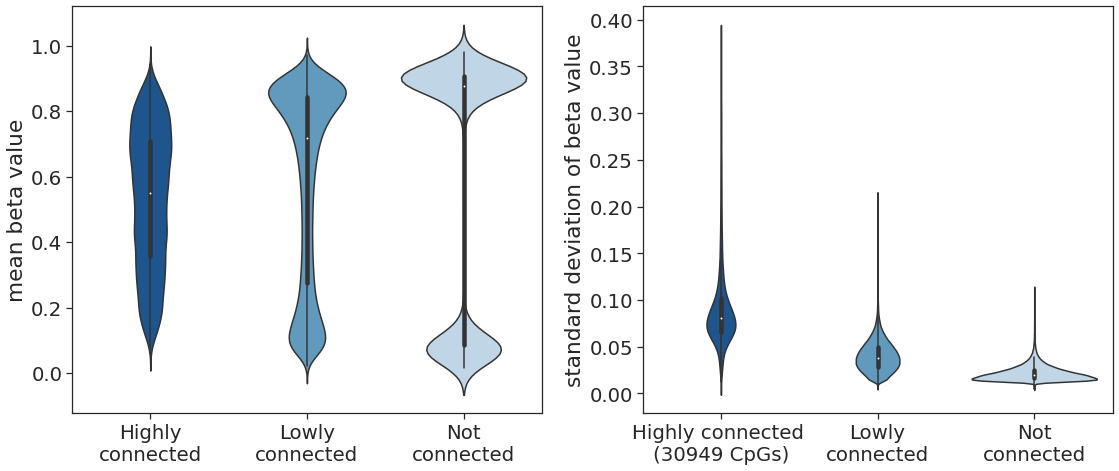

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,7))
sns.violinplot(data=[all_mean_high, all_mean_low, all_mean_none], palette=[c_high, c_low, c_none], ax=ax1)
ax1.set_xticklabels(["Highly\nconnected", "Lowly\nconnected", "Not\nconnected"])
ax1.set_ylabel("mean beta value")

sns.violinplot(data=[all_std_high, all_std_low, all_std_none], palette=[c_high, c_low, c_none], ax=ax2)
ax2.set_xticklabels(["Highly\nconnected", "Lowly\nconnected", "Not\nconnected"])
ax2.set_ylabel("standard deviation of beta value")
#ax.set_title("Lower connectivity = lower variability of beta")
plt.tight_layout()
plt.savefig(f"figures/global_connectivity_sampleHeterogeneity.png")

# print(mannwhitneyu(all_std_none, all_std_high))
# print(mannwhitneyu(all_std_none, all_std_low))
# print(mannwhitneyu(all_std_high, all_std_low))

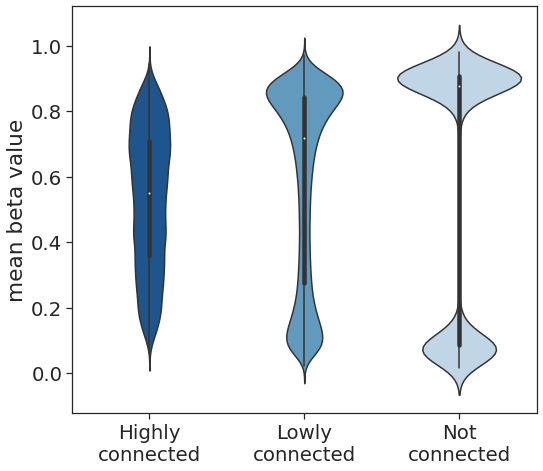

In [28]:
fig, ax = plt.subplots(figsize=(8,7))
sns.violinplot(data=[all_mean_high, all_mean_low, all_mean_none], palette=[c_high, c_low, c_none])
ax.set_xticklabels(["Highly\nconnected", "Lowly\nconnected", "Not\nconnected"])
ax.set_ylabel("mean beta value")
#ax.set_title("Lower connectivity = lower variability of beta")
plt.tight_layout()
#plt.savefig(f"figures/global_connectivity_stdBeta.png")